In [233]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import numpy as np
import numpy as np
from matplotlib import cm, pyplot as plt


In [234]:
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [235]:
import pandas as pd
import os
init_dir_path = str(os.getcwd())  # find current working directory
stock_paths=[init_dir_path+'/stock_data/'+x+'_prices.csv' for x in stocks]

In [236]:
features=['Return','Volatility','HighR','LowR']


In [237]:
data_full=[]
for sp in stock_paths:
    s=pd.read_csv(sp)
    #s=s.drop(['High','Low','Volume'],axis=1)
    s['Return']=100*(s['Close']-s['Open'])/s['Open']
    s['HighR']=100*(s['High']-s['Open'])/s['Open']
    s['LowR']=100*(s['Low']-s['Open'])/s['Open']
    s['Volatility']=s['Return'].rolling(window=3).std()
    s['Date']=pd.to_datetime(s['Date'])
    s=s.iloc[3:]
    s=s.reset_index(drop=True)
    s[features]=StandardScaler().fit_transform(s[features])
    data_full.append(s)

In [238]:
data=[x[features] for x in data_full]

In [239]:
def plot_in_sample_hidden_states(hmm_model, df, features):
    """
    Plot the adjusted closing prices masked by 
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    rets = df[features]
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot(
            df.index[mask], 
            df["Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title(f"Hidden State #{i}")
        # ax.xaxis.set_major_locator(HourLocator(interval=1))  # Major ticks at every hour
        # ax.xaxis.set_minor_locator(MinuteLocator(interval=15))  # Minor ticks every 15 minutes
        ax.grid(True)
    plt.show()

In [240]:
xdata=np.concatenate(data)
lengths=[len(x) for x in data]
model=GaussianHMM(n_components=2,n_iter=10000,tol=1e-5)
model.fit(xdata,lengths)

#plot_in_sample_hidden_states(model,split_sets[i].iloc[train],features)


GaussianHMM(n_components=2, n_iter=10000, tol=1e-05)

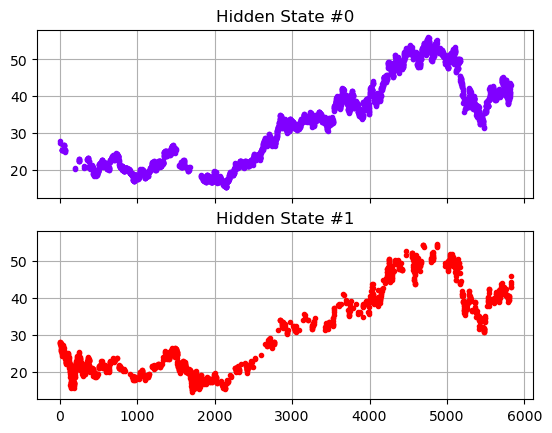

In [241]:
plot_in_sample_hidden_states(model,data_full[-1],features)


In [242]:
l=[]
for (i,x) in enumerate(data):
    x['State']=pd.Series(model.predict(x[features]))
    a=x[x['State']==0]['Return'].sum()
    b=x[x['State']==1]['Return'].sum()
    l.append((a,b))
    if a > b:
        x['State']=1-x['State']
    x['Ticker']=stocks[i]


/tmp/ipykernel_14820/2785762527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['State']=pd.Series(model.predict(x[features]))
/tmp/ipykernel_14820/2785762527.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['State']=1-x['State']
/tmp/ipykernel_14820/2785762527.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [243]:
#State 0 is bear, State 1 is bullish
#checking consistency
l

[(np.float64(80.03524131626727), np.float64(-80.03524131626719)),
 (np.float64(83.9616846012765), np.float64(-83.96168460127643)),
 (np.float64(123.44900423484451), np.float64(-123.44900423484452)),
 (np.float64(117.94467121530198), np.float64(-117.94467121530195)),
 (np.float64(51.15986249985566), np.float64(-51.15986249985575)),
 (np.float64(90.73264124516368), np.float64(-90.7326412451636)),
 (np.float64(73.1712309519906), np.float64(-73.1712309519906))]

In [244]:
total=pd.concat(data).reset_index(drop=True)
total.to_csv('stock_hmm_output.csv')